# Task 6: Stable Diffusion Fine-Tuning (LoRA)
Implements lightweight LoRA fine-tuning workflow on a small dataset.

## 1. Install Dependencies

In [1]:
%pip install -q diffusers==0.29.0 accelerate transformers safetensors peft datasets torchvision
%pip install huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Imports & Config

In [2]:
import torch, os, math, json, time
from pathlib import Path
from datasets import load_dataset
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model
from torch import nn
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
MODEL_ID='runwayml/stable-diffusion-v1-5'
OUT='task6_sd_lora'; Path(OUT).mkdir(exist_ok=True)

d:\acm\models\jul25\nullclass\.venv\Lib\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## 3. Dataset (Replace With Custom) 

In [3]:
# Public dataset example: Flowers 102 (create captions from class labels)
dataset = load_dataset("huggan/flowers-102-categories", split="train[:200]")  # small subset for demo

# Some cached variants may miss 'label'. Add a dummy label if absent to avoid KeyError.
if "label" not in dataset.features:
    dataset = dataset.add_column("label", [0] * len(dataset))
    class_names = ["flower"]
else:
    class_names = dataset.features["label"].names

def add_prompt(example):
    label_name = class_names[example["label"]] if "label" in example else "flower"
    example["prompt"] = f"A high quality photo of a {label_name} flower"
    return example

dataset = dataset.map(add_prompt)

from torchvision import transforms
preproc = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
])

def collate(batch):
    images = [preproc(b["image"])*2-1 for b in batch]  # scale to [-1,1]
    prompts = [b["prompt"] for b in batch]
    return torch.stack(images), prompts

from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate)

## 4. Load Pipeline + LoRA Inject

In [4]:
# Work around CAS/XetHub transfer failures by disabling experimental backends before download.
# The runtime error you saw originated from transfer.xethub.hf.co (HF Xet integration).
os.environ.setdefault("HF_HUB_ENABLE_HF_XET", "0")
os.environ.setdefault("HF_HUB_DISABLE_HF_TRANSFER", "1")  # also disable hf-transfer ranged downloader

def _load_pipe():
	kwargs = {
		"torch_dtype": torch.float16 if DEVICE == 'cuda' else torch.float32
	}
	try:
		return StableDiffusionPipeline.from_pretrained(MODEL_ID, **kwargs)
	except OSError as oe:
		# Handle incomplete / corrupt cache where diffusion_pytorch_model.bin is missing.
		if "diffusion_pytorch_model.bin" in str(oe):
			print("Detected incomplete model cache (missing diffusion_pytorch_model.bin). Forcing clean re-download...")
			return StableDiffusionPipeline.from_pretrained(
				MODEL_ID,
				force_download=True,
				resume_download=False,
				**kwargs
			)
		raise

try:
	pipe = _load_pipe()
except Exception as e:
	print("Initial model load failed, retrying:", e)
	# Force disable again (in case env was changed) and retry once (with forced download if needed).
	os.environ["HF_HUB_ENABLE_HF_XET"] = "0"
	os.environ["HF_HUB_DISABLE_HF_TRANSFER"] = "1"
	pipe = _load_pipe()

pipe.to(DEVICE)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# Apply LoRA to UNet attention blocks
lora_config = LoraConfig(r=4, lora_alpha=8, target_modules=['to_q','to_k','to_v','to_out.0'], lora_dropout=0.05)
pipe.unet = get_peft_model(pipe.unet, lora_config)
trainable = [n for n,p in pipe.unet.named_parameters() if p.requires_grad]
len(trainable), trainable[:5]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

d:\acm\models\jul25\nullclass\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GOVARDHAN SATYA\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

(256,
 ['base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight',
  'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight',
  'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight',
  'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight',
  'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight'])

## 5. Training Loop (Simplified) 

C:\Users\GOVARDHAN SATYA\AppData\Local\Temp\ipykernel_5748\2506228018.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))
d:\acm\models\jul25\nullclass\.venv\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
C:\Users\GOVARDHAN SATYA\AppData\Local\Temp\ipykernel_5748\2506228018.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
d:\acm\models\jul25\nullclass\.venv\Lib\s

Step 10/100 loss 0.0455
Step 20/100 loss 0.0022
Step 20/100 loss 0.0022
Step 30/100 loss 0.0045
Step 30/100 loss 0.0045
Step 40/100 loss 0.1259
Step 40/100 loss 0.1259
Step 50/100 loss 0.0053
Step 50/100 loss 0.0053
Step 60/100 loss 0.0063
Step 60/100 loss 0.0063
Step 70/100 loss 0.2173
Step 70/100 loss 0.2173
Step 80/100 loss 0.1039
Step 80/100 loss 0.1039
Step 90/100 loss 0.2594
Step 90/100 loss 0.2594
Step 100/100 loss 0.1036
Step 100/100 loss 0.1036


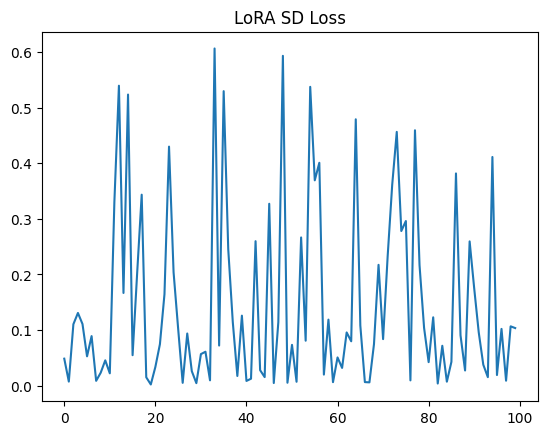

In [5]:
optim = torch.optim.Adam(pipe.unet.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))
STEPS=100
pipe.unet.train()
losses=[]
for step, (images, prompts) in enumerate(loader):
    if step>=STEPS: break
    images=images.to(DEVICE)
    with torch.no_grad():
        text_inputs = pipe.tokenizer(prompts, padding='max_length', max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors='pt').to(DEVICE)
        text_embeds = pipe.text_encoder(**text_inputs)[0]
        latents = pipe.vae.encode(images).latent_dist.sample()*0.18215
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (latents.shape[0],), device=DEVICE, dtype=torch.long)
    noisy = pipe.scheduler.add_noise(latents, noise, timesteps)
    with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
        model_out = pipe.unet(noisy, timesteps, encoder_hidden_states=text_embeds).sample
        if pipe.scheduler.config.prediction_type=='epsilon':
            target = noise
        else:
            raise ValueError('Unsupported prediction_type')
        loss = (model_out - target).pow(2).mean()
    scaler.scale(loss).backward()
    scaler.step(optim); scaler.update(); optim.zero_grad()
    losses.append(loss.item())
    if (step+1)%10==0: print(f'Step {step+1}/{STEPS} loss {loss.item():.4f}')
import matplotlib.pyplot as plt; plt.plot(losses); plt.title('LoRA SD Loss'); plt.savefig(f'{OUT}/loss.png'); plt.show()

## 6. Save LoRA Weights

In [6]:
pipe.unet.save_pretrained(f'{OUT}/unet_lora')
pipe.text_encoder.save_pretrained(f'{OUT}/text_encoder')
pipe.tokenizer.save_pretrained(f'{OUT}/tokenizer')
len(losses)

100

## 7. Inference with Fine-Tuned Model

  0%|          | 0/30 [00:00<?, ?it/s]

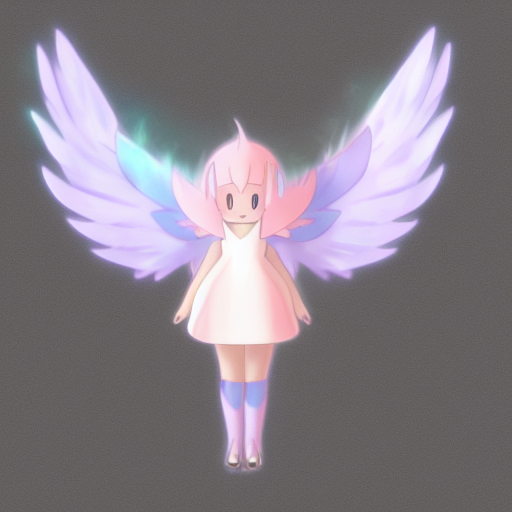

In [7]:
pipe.unet.eval()
prompt='A cute pastel pokemon creature with wings'
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image.save(f'{OUT}/sample.png')
image

## 8. Save Metadata

In [8]:
import json, time
meta={'steps':len(losses), 'avg_loss':sum(losses)/len(losses), 'prompt':prompt} 
json.dump(meta, open(f'{OUT}/meta.json','w'), indent=2); meta

{'steps': 100,
 'avg_loss': 0.14822490390390158,
 'prompt': 'A cute pastel pokemon creature with wings'}

## 9. Summary
LoRA fine-tune complete (demo). Extend steps/epochs and dataset for higher quality.